In [1]:
# Author: Antti Kiviaho
# Date: 10.5.2023

import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from scripts.utils import load_from_pickle

import seaborn as sns
import matplotlib.pyplot as plt


## Function definitions

In [2]:

def calculate_matrix_orders(arr):
    # get the indices that would sort each row of the array
    sort_indices = np.argsort(-arr, axis=1)

    # create an array to mark the sorted order
    sorted_order = np.empty_like(sort_indices)
    rows, cols = np.indices(arr.shape)
    sorted_order[rows, sort_indices] = cols

    # replace each entry in the original array with its index in the sorted order
    result = sorted_order.astype(int)

    return result



def get_genes_by_factor(res):
    gene_w = res['gene_weights'].T
    genes = list(res['genes'].index)

    # create ranking matrices from the NMF weights
    mat_1 = calculate_matrix_orders(gene_w.T).T
    mat_2 = calculate_matrix_orders(gene_w)

    # Iterate through the factors (columns)
    genes_by_factors = {}
    for factor in range(gene_w.shape[1]):
        valid_genes = list()
        # Iterate through the genes, starting from the highest weighted gene of this factor
        for i in np.argsort(mat_1[:,factor]): 
            if mat_2[i,factor] ==0: # Is this the factor the gene effects the most?
                
                # If yes, add it to the list of genes
                valid_genes.append(genes[i])
            else:
                # if not, stop adding genes into the list, move on to the next factor
                break 
        # Append the list of valid genes into a dictionary under the appropriate key
        genes_by_factors['factor'+str(factor)] = valid_genes
    
    return genes_by_factors

def score_modules(ctype, n_comps):
    dat = sc.read_h5ad(ctype + '.h5ad')
    dat.X = dat.layers['counts'].copy()

    res = load_from_pickle('sc_modules/data/'+ctype+'_'+str(n_comps)+'_modules_nsnmf_results.pickle')
    genes_dict = get_genes_by_factor(res)
    for k in genes_dict.keys():
        lst = genes_dict[k]

        # Score the gene expression data.
        sc.tl.score_genes(dat, gene_list=lst, score_name=k)

    # Find the column with the highest score and add a new column for the corresponding factor.
    score_cols = list(genes_dict.keys())
    max_col = dat.obs[score_cols].idxmax(axis=1)
    dat.obs['max_factor'] = max_col

    obs_with_scores = dat.obs.copy()
    del dat

    return(obs_with_scores,genes_dict)

def summarize_factor(df, factor, g_dict):
    n_present = len(np.unique(df[df['max_factor']==factor]['sample']))
    n_dsets = len(np.unique(df[df['max_factor']==factor]['dataset']))
    n_total = len(df['sample'].cat.categories)
    print('Phenotype distribution:')
    print(df[df['max_factor'] == factor]['phenotype'].value_counts())
    print('')
    print('Present in '+str(n_present)+' out of '+str(n_total)+
    ' samples and ' + str(n_dsets) + ' datasets.')
    print('')
    print('Top 20 contributing genes:')
    for g in g_dict[factor][:20]:
        print(g)
    
def plot_score_violins(scores_df):
    # Take all columns with factor in their name
    factor_columns = [col for col in scores_df.columns if 'factor' in col]
    # Drop the size_factors column
    factor_columns = [f for f in factor_columns if f != 'size_factors']

    if len(factor_columns) > 0:
        violin_df = scores_df[factor_columns]

        rows = len(factor_columns)//2
        fig, axs = plt.subplots(rows, 2, figsize=(15, 5 * rows))

        for i in range(len(factor_columns)-1): # Don't plot the last column
            row = i // 2
            col = i % 2
            
            sns.violinplot(data=violin_df, x='max_factor', y=factor_columns[i], ax=axs[row][col])

        plt.show()
    else:
        print("No columns found with 'factor' in their names.")



## Loading the NMF gene lists and scoring them

In [140]:
# The number of components used is determined as the highest 
# n that yileds at least 20 unique genes in each component.
# Very similar to the one used in Barkley et al. Nat Genetics 2022

nmf_components_by_ctype = {
    'T_cell': 5,
    'Myeloid': 6,
    'Fibroblast_muscle': 5,
    'Epithelial': 5,
    }

# Create a dataframe for the final annotations 
final_annotations = pd.DataFrame()

In [126]:
# Put them all in a single list and plot the upsetplot
import upsetplot as ups

genes_by_factors = {}
for ctype in nmf_components_by_ctype.keys():
    n_comps = nmf_components_by_ctype[ctype]

    res = load_from_pickle('sc_modules/data/'+ctype+'_'+str(n_comps)+'_modules_nsnmf_results.pickle')

    gene_w = res['gene_weights'].T
    genes = list(res['genes'].index)

    # create ranking matrices from the NMF weights
    mat_1 = calculate_matrix_orders(gene_w.T).T
    mat_2 = calculate_matrix_orders(gene_w)

    # Iterate through the factors (columns)
    for factor in range(gene_w.shape[1]):
        valid_genes = list()
        # Iterate through the genes, starting from the highest weighted gene of this factor
        for i in np.argsort(mat_1[:,factor]): 
            if mat_2[i,factor] ==0: # Is this the factor the gene effects the most?
                
                # If yes, add it to the list of genes
                valid_genes.append(genes[i])
            else:
                # if not, stop adding genes into the list, move on to the next factor
                break 
        # Append the list of valid genes into a dictionary under the appropriate key
        genes_by_factors[ctype+'_factor'+str(factor)] = valid_genes

ups_data = ups.from_contents(genes_by_factors)
ax_dict = ups.UpSet(ups_data, subset_size='count',show_counts=True).plot()

    

### Epithelial

/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.

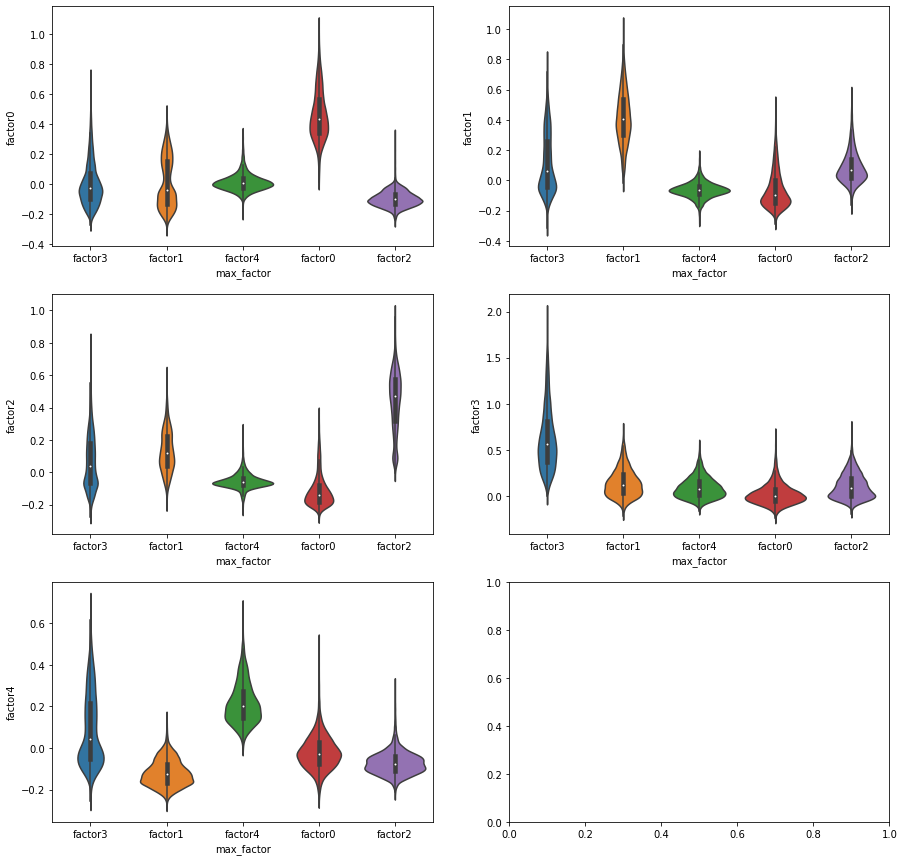

factor3    29410
factor2    19402
factor0    15932
factor1    10734
factor4     6916
Name: max_factor, dtype: int64

In [130]:
scores, genes_dict = score_modules('Epithelial',nmf_components_by_ctype['Epithelial'])
plot_score_violins(scores)
scores['max_factor'].value_counts()

In [131]:
g_of_interest = 'FOSB'
for k in genes_dict.keys():
    for i,g in  enumerate(genes_dict[k]):
        if g == g_of_interest:
            print('Its present in '+ k + ' at index '+ str(i))

Its present in factor4 at index 56


In [138]:
for g in genes_dict['factor0']:
    print(g)

TMSB10
S100A10
S100A16
PPP1R14B
S100A6
HMGA1
KRT7
PHLDA3
SRM
MALL
SFN
SOD2
ITGA2
PHLDA2
S100A14
S100A2
CAV2
S100P
COTL1
GCLM
GPRC5A
TYMP
MAL2
TM4SF1
CD55
TMEM45B
CEACAM1
SDCBP2
SERPINB1
ITGA3
AQP3
TXNRD1
PLIN2
TINAGL1
FOSL1
ODC1
ISG20
CYP1B1
LAMC2
KRT17
PIM1
DUSP5
LMO7
CYBA
SDC1
PTGES
GJB3
PSME2
NABP1
RAP2B
ARNTL2
GPX2
KATNBL1
CAV1
MIR22HG
SOWAHC
EMP3
PLCD3
PHLDA1
LAMB3
PRSS3
LYPD3
TMPRSS4
SLC16A3
TNFAIP2
AGO2
MT2A
SLC7A5
ST3GAL4
OAS1
NEAT1
MUC1
CYP3A5
TMEM40
TRIM16
CDKN2B
EMP1
ST3GAL1
ANKRD36C
MYC
SLC7A11
KRT19
APOL2
SPHK1
SPINK1
GK
CDC42EP1
SERPINB5
LURAP1L
HMOX1
BIRC3
CXCL17
KRT23
EPHA2
RAB31
PLAUR
CLDN1
IER3
DENND2C
DGKH
PSCA
AKR1C2
LINC00342
PITX1
OAF
SRD5A3
FSTL3
PLAT
ITGB6
RELB
GCLC
FSCN1
PTGR1
CITED4
RNF213
UPP1
LIPH
GJB4
PPARG
DUSP14
PLAU
HPGD
FOXQ1
AXL
HAS3
AKR1B1
PTGS2
ID1
AMIGO2
FERMT1
GAL
MANF
NAMPT
DUOX2
FA2H
AKR1C1
SNCG
OAS3
GADD45A
LCN2
CLCF1
SPTSSB
DKK1
AKR1C3
TMEM92
CDKN2A
FGFBP1
CD68
AREG
GALNT5
TRIM31
SHH
HSD17B2
UCP2
PMAIP1
RAB11FIP1
CLEC2B
SOX15
APOL1
CTSS
PRSS22


In [141]:
summarize_factor(scores,'factor0',genes_dict)

Phenotype distribution:
CRPC      0
PCa       0
normal    0
Name: phenotype, dtype: int64

Present in 0 out of 97 samples and 0 datasets.

Top 20 contributing genes:
TMSB10
S100A10
S100A16
PPP1R14B
S100A6
HMGA1
KRT7
PHLDA3
SRM
MALL
SFN
SOD2
ITGA2
PHLDA2
S100A14
S100A2
CAV2
S100P
COTL1
GCLM


In [142]:
summarize_factor(scores,'factor1',genes_dict)

Phenotype distribution:
CRPC      0
PCa       0
normal    0
Name: phenotype, dtype: int64

Present in 0 out of 97 samples and 0 datasets.

Top 20 contributing genes:
TRPM4
TMC5
FNIP2
PCA3
OR51E2
AAK1
ARHGEF26
PDLIM5
ERG
DICER1
PRDX2
CLDN8
HPN
GOLM1
FOLH1
VSTM2L
RALGAPA2
TMEM56
AMACR
CREB3L1


In [143]:
summarize_factor(scores,'factor2',genes_dict)

Phenotype distribution:
CRPC      0
PCa       0
normal    0
Name: phenotype, dtype: int64

Present in 0 out of 97 samples and 0 datasets.

Top 20 contributing genes:
KLK3
KLK2
AZGP1
SLC45A3
STEAP2
RDH11
NKX3-1
ACPP
FAM213A
AGTRAP
SLC30A4
IDH1
NME4
CKB
RPN2
RCAN3
NDRG1
DBI
PDIA6
TM7SF2


In [144]:
summarize_factor(scores,'factor3',genes_dict)

Phenotype distribution:
CRPC      0
PCa       0
normal    0
Name: phenotype, dtype: int64

Present in 0 out of 97 samples and 0 datasets.

Top 20 contributing genes:
HSPA8
DNAJB1
HSPA1A
PPP1R15A
HSPA1B
DNAJA1
RHOB
RNASEK
ATP6V0C
HSPE1
ZFP36
UBB
PRAC1
HSPH1
IER2
CACYBP
BAG3
JUN
MARCKSL1
NR4A1


In [145]:
summarize_factor(scores,'factor4',genes_dict)

Phenotype distribution:
CRPC      0
PCa       0
normal    0
Name: phenotype, dtype: int64

Present in 0 out of 97 samples and 0 datasets.

Top 20 contributing genes:
PDLIM1
DDIT4
ZFP36L1
SGK1
MEIS2
SYNE2
CD82
NBEAL1
KRT15
PYCARD
THSD4
TNFSF10
GJA1
CYP4B1
SLC40A1
ARRDC2
NTN4
FLRT3
PIK3R1
PALLD


In [146]:
# Rename the columns accordingly
scores['max_factor'] = scores['max_factor'].replace('factor0', 'prostaglandind active epithelium')
scores['max_factor'] = scores['max_factor'].replace('factor1', 'ERG tumor epithelium')
scores['max_factor'] = scores['max_factor'].replace('factor2', 'luminal-like epithelium')
scores['max_factor'] = scores['max_factor'].replace('factor3', 'stressed epithelium')
scores['max_factor'] = scores['max_factor'].replace('factor4', 'basal-like epithelium')
final_annotations = pd.concat([final_annotations,scores['max_factor']],axis=0)

### T cell

In [147]:
scores, genes_dict = score_modules('T_cell',nmf_components_by_ctype['T_cell'])
scores['max_factor'].value_counts()

/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.

factor2    46393
factor4    36323
factor0    15276
factor3     5251
factor1     4471
Name: max_factor, dtype: int64

In [148]:
g_of_interest = 'CD3D'
for k in genes_dict.keys():
    for i,g in  enumerate(genes_dict[k]):
        if g == g_of_interest:
            print('Its present in '+ k + ' at index '+ str(i))

In [149]:
for g in genes_dict['factor4']:
    print(g)

TOB1
KLRB1
ZFP36
EEF1A1
DDIT4
CCL4
TSC22D3
MRPL1
CCR6
GTF2B
HOPX
CXCR4
ANKRD28
ZC3H12A
DDIT3
CKS2
IL7R
PDCL3
ARL4A
GPR171
CYCS
AQP3
SNAPC1
IFNGR1
CREM
NFKBID
FTH1
ID2
PTGER2
PDCD1
CD40LG
RILPL2
BCAS2
RGS1
CCL5
CXCR6
BTG2
SERTAD1
LSR
FAS
MYBL1
GLUL
CDC42EP3
XCL2
TUBB2A
FTL


In [150]:
summarize_factor(scores,'factor0',genes_dict)

Phenotype distribution:
normal    7426
PCa       7279
CRPC       571
Name: phenotype, dtype: int64

Present in 86 out of 96 samples and 7 datasets.

Top 20 contributing genes:
PFN1
TMSB4X
HLA-DRA
MTRNR2L8
HLA-DPB1
PSME2
MTRNR2L12
STMN1
CD8B
CD7
TUBB
HLA-DRB5
TIMP1
HLA-DRB1
MTRNR2L1
HMGN2
HMGB2
RANBP1
GAPDH
HLA-DQA1


In [151]:
summarize_factor(scores,'factor1',genes_dict)

Phenotype distribution:
PCa       2523
normal    1837
CRPC       111
Name: phenotype, dtype: int64

Present in 78 out of 96 samples and 7 datasets.

Top 20 contributing genes:
CTSW
NKG7
IFITM1
CST7
TYROBP
GNLY
LDHA
FCER1G
EFHD2
CALR
HLA-B
RBM38
PRF1
IL2RB
KLRD1
DNAJC1
KLRF1
RAC1
GZMA
GABARAP


In [152]:
summarize_factor(scores,'factor2',genes_dict)

Phenotype distribution:
PCa       32514
normal    12110
CRPC       1769
Name: phenotype, dtype: int64

Present in 90 out of 96 samples and 7 datasets.

Top 20 contributing genes:
DNAJB1
DUSP1
HSPA1A
HSPA1B
UBC
PNRC1
CSRNP1
H1FX
HSP90AB1
HSPH1
BTG1
NR4A1
RPL17
DNAJA1
ZFP36L2
JUN
RGCC
PPP1R15A
SLC2A3
PLK3


In [153]:
summarize_factor(scores,'factor3',genes_dict)

Phenotype distribution:
normal    2905
PCa       2244
CRPC       102
Name: phenotype, dtype: int64

Present in 68 out of 96 samples and 7 datasets.

Top 20 contributing genes:
BATF
TBC1D4
CD27
LTB
JUNB
TNFRSF18
BIRC3
GADD45B
GADD45A
IL2RA
TSHZ2
GPR183
SLAMF1
MAF
SAT1
TIGIT
ARID5B
TNFRSF4
SELL
ICA1


In [154]:
summarize_factor(scores,'factor4',genes_dict)

Phenotype distribution:
normal    24856
PCa       11430
CRPC         37
Name: phenotype, dtype: int64

Present in 65 out of 96 samples and 7 datasets.

Top 20 contributing genes:
TOB1
KLRB1
ZFP36
EEF1A1
DDIT4
CCL4
TSC22D3
MRPL1
CCR6
GTF2B
HOPX
CXCR4
ANKRD28
ZC3H12A
DDIT3
CKS2
IL7R
PDCL3
ARL4A
GPR171


In [155]:
# Rename the columns accordingly
scores['max_factor'] = scores['max_factor'].replace('factor0', 'cytotoxic T cells')
scores['max_factor'] = scores['max_factor'].replace('factor1', 'natural killer cells')
scores['max_factor'] = scores['max_factor'].replace('factor2', 'stressed T cells')
scores['max_factor'] = scores['max_factor'].replace('factor3', 'regulatory T cells')
scores['max_factor'] = scores['max_factor'].replace('factor4', 'helper T cells')
final_annotations = pd.concat([final_annotations,scores['max_factor']],axis=0)

### Myeloid

/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.

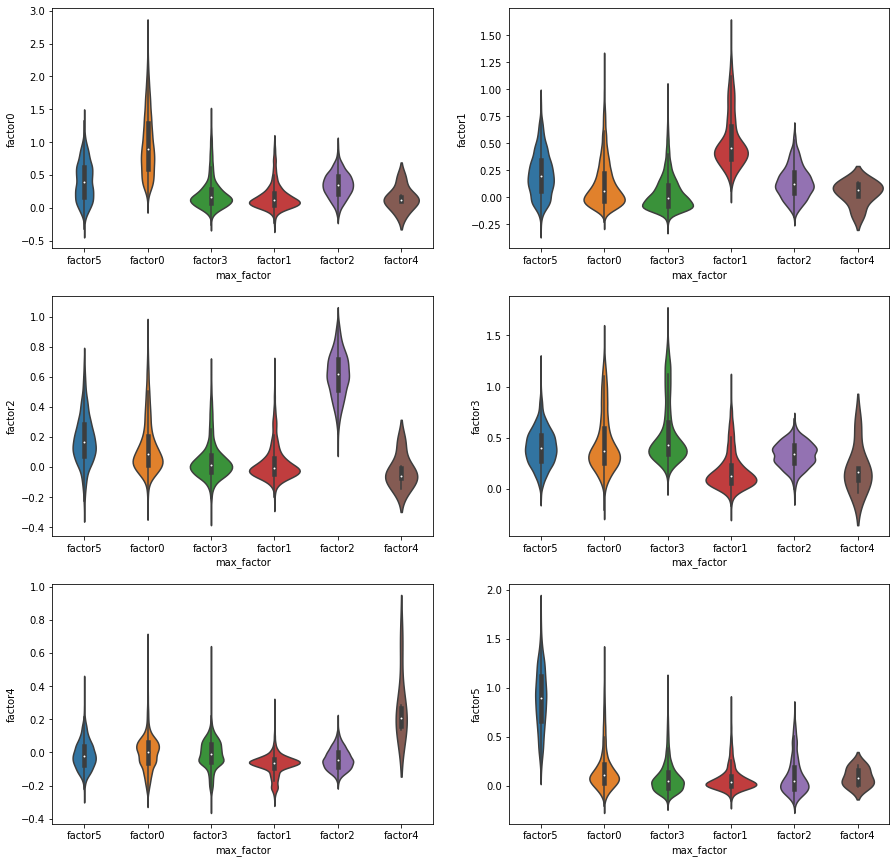

factor0    9901
factor3    8912
factor1    3375
factor5    1952
factor2     895
factor4       6
Name: max_factor, dtype: int64

In [156]:
scores, genes_dict = score_modules('Myeloid',nmf_components_by_ctype['Myeloid'])
plot_score_violins(scores)
scores['max_factor'].value_counts()

In [157]:
g_of_interest = 'TREM1'
for k in genes_dict.keys():
    for i,g in  enumerate(genes_dict[k]):
        if g == g_of_interest:
            print('Its present in '+ k + ' at index '+ str(i))

Its present in factor1 at index 43


In [158]:
for g in genes_dict['factor5']:
    print(g)

FTL
PLD3
CD63
BRI3
LGALS1
APOE
CTSD
ATOX1
APOC1
LGALS3
CSTB
CALM3
CD68
ACP5
TSPAN4
ANXA2
CFD
OTOA
NUPR1
LGMN
NPL
CD9
CTSZ
RAB13
ASAH1
CAPG
GCHFR
NENF
HMGA1
CHCHD10
TMEM176A
SMPDL3A
CHCHD6
FABP5
PTMS
PMP22
C2
FUCA1
HM13
GPNMB
CCL4
KCNMA1
ACP2
EPHX1
CCL3
FABP3
CREG1
SDC3
DAB2
PLTP
VAT1
MGLL
PRDX1
LAMP1
C1QA
CYSTM1
TPPP3
DBI
PLA2G7
CD59
CYB5A
LIPA
MYL9
CCL4L2
CPM
IFI27
BLVRB
SPARC
CCL2
NPY
PPP1R14B


In [159]:
summarize_factor(scores,'factor0',genes_dict)

Phenotype distribution:
PCa       7224
normal    2203
CRPC       474
Name: phenotype, dtype: int64

Present in 97 out of 98 samples and 7 datasets.

Top 20 contributing genes:
DNAJB1
HSPA1A
HSPB1
HSPA1B
HSPE1
HSP90AA1
FOS
CACYBP
MRPL18
ZFAND2A
PPP1R15A
HSPA8
HSPD1
UBC
UBB
RHOB
NR4A1
CKS2
IER2
KLF2


In [160]:
summarize_factor(scores,'factor1',genes_dict)

Phenotype distribution:
PCa       1745
normal    1521
CRPC       109
Name: phenotype, dtype: int64

Present in 87 out of 98 samples and 7 datasets.

Top 20 contributing genes:
SOD2
BCL2A1
PNRC1
PLAUR
S100A4
FTH1
G0S2
IL1B
S100A6
FCN1
LYZ
GK
C5AR1
BTG1
EREG
SLC11A1
SERPINA1
CFP
CXCL2
SERPINB1


In [161]:
summarize_factor(scores,'factor2',genes_dict)

Phenotype distribution:
PCa       736
normal    159
CRPC        0
Name: phenotype, dtype: int64

Present in 24 out of 98 samples and 4 datasets.

Top 20 contributing genes:
CD83
CYBB
BHLHE40
PTGER4
CD81
ARL4C
A2M
PSAP
MAFF
MACF1
NR4A3
KLF6
CYFIP1
CPVL
GRASP
DOCK4
C3
VASH1
OGFRL1
EZR


In [162]:
summarize_factor(scores,'factor3',genes_dict)

Phenotype distribution:
PCa       5130
normal    3515
CRPC       267
Name: phenotype, dtype: int64

Present in 98 out of 98 samples and 7 datasets.

Top 20 contributing genes:
CD74
ACTB
PKIB
RPL17
GABARAP
TUBA1B
HLA-DRB1
PLD4
PLAC8
TUBB
HLA-DRA
IGFLR1
PPA1
HLA-DQB1
ALOX5AP
COTL1
HMGN2
YWHAH
STMN1
CST3


In [163]:
summarize_factor(scores,'factor4',genes_dict)

Phenotype distribution:
normal    5
PCa       1
CRPC      0
Name: phenotype, dtype: int64

Present in 5 out of 98 samples and 3 datasets.

Top 20 contributing genes:
CD7
CCL5
CD3D
IL32
CD2
CD3E
GIMAP7
ITM2C
IGF1
KLRB1
NKG7
CTSW
GPR82
C1QC
TXNIP
SPON2
LCK
GZMA
CD8A
GPR171


In [164]:
summarize_factor(scores,'factor5',genes_dict)

Phenotype distribution:
PCa       975
CRPC      782
normal    195
Name: phenotype, dtype: int64

Present in 86 out of 98 samples and 7 datasets.

Top 20 contributing genes:
FTL
PLD3
CD63
BRI3
LGALS1
APOE
CTSD
ATOX1
APOC1
LGALS3
CSTB
CALM3
CD68
ACP5
TSPAN4
ANXA2
CFD
OTOA
NUPR1
LGMN


In [165]:
# Rename the columns accordingly
scores['max_factor'] = scores['max_factor'].replace('factor0', 'stressed myeloids')
scores['max_factor'] = scores['max_factor'].replace('factor1', 'tumor inflammatory monocytes')
scores['max_factor'] = scores['max_factor'].replace('factor2', 'dendritic-like myoeloids')
scores['max_factor'] = scores['max_factor'].replace('factor3', 'antigen-presenting macrophages')
#scores['max_factor'] = scores['max_factor'].replace('factor4', '') # Remove factor 4 since it scores high in so few cells
scores = scores[~(scores['max_factor'] == 'factor4')]
scores['max_factor'] = scores['max_factor'].replace('factor5', 'macrophages')
final_annotations = pd.concat([final_annotations,scores['max_factor']],axis=0)

### Fibroblasts

/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.

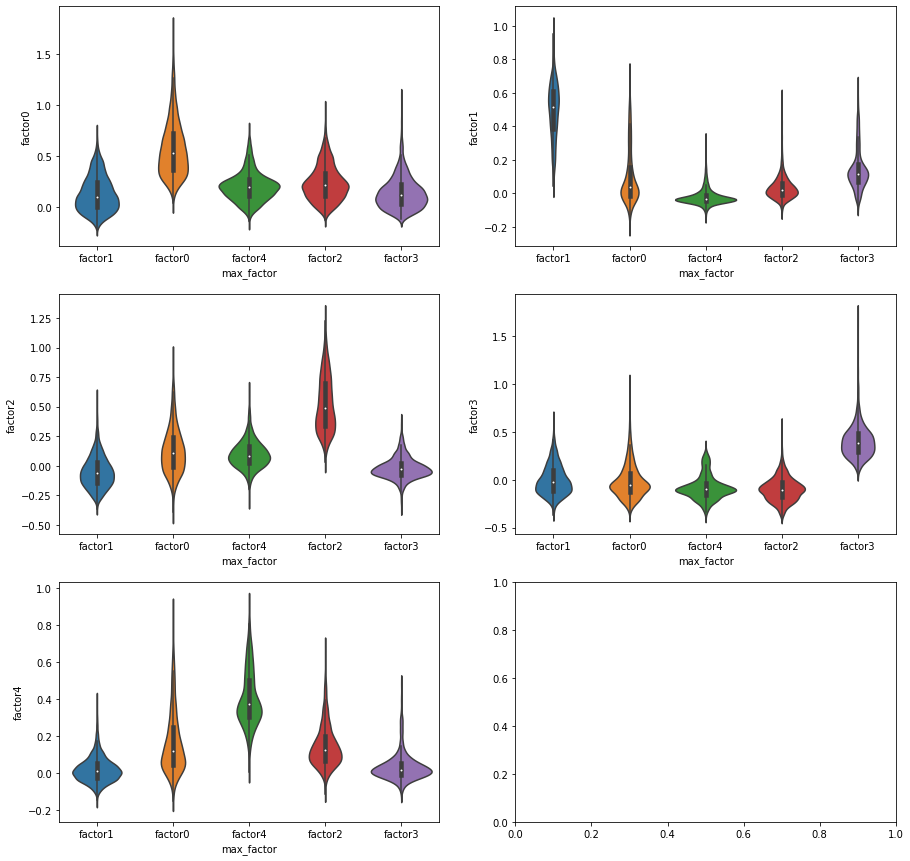

factor0    7311
factor1    4163
factor4    3869
factor2    3595
factor3    1802
Name: max_factor, dtype: int64

In [166]:
ctype = 'Fibroblast_muscle'
scores, genes_dict = score_modules(ctype,nmf_components_by_ctype[ctype])
plot_score_violins(scores)
scores['max_factor'].value_counts()

In [167]:
g_of_interest = 'CXCL3'
for k in genes_dict.keys():
    for i,g in  enumerate(genes_dict[k]):
        if g == g_of_interest:
            print('Its present in '+ k + ' at index '+ str(i))

In [168]:
for f in genes_dict['factor4']:
    print(f)

TPM2
TAGLN
CNN1
PLN
MYLK
ACTA2
NEXN
SORBS2
NTRK2
NET1
FILIP1
FHL1
LMOD1
MCAM
PPP1R12B
RERGL
CSRP1
MRVI1
SYNPO2
UTRN
SYNE2
AOC3
SNCG
PPP1R14A
FKBP5
PDLIM5
CRIM1
FHL5
CKB
FAM129A
PARM1
FBXO32
PCP4
ATP2B4
KCNAB1
MAP3K7CL
BCAM
CCDC3
SLC38A1
GADD45B
SYNM
SLC7A2
SLIT3
SORT1
RAMP1
MACF1
CDH6
CCNH
PHLDB2
ITGA8
MTRNR2L8
NPNT
PDE3A
MYH11
ATP1A2
KCNA5
GNAS
KCNMB1
ADAMTS1
VPS13D
PDLIM3
MYOCD
GBP2
CSPG4
APOLD1
RRAS
ACTG2
TIMP3
PLCE1
ADRA2A
NRGN
DST
BTG2
PDGFA
SLC38A11
MTRNR2L12
PHLDA2
KCNMA1
TBX2
TSPAN2
ZNF331
ACAN
SYTL2
SUSD5
SYNGR2
RHOQ
MAOA
EDIL3
INPP4B
MTRNR2L1
ITGA1
SBSPON
CDH13
GADD45G
NOV
SERPINI1
ETS2
METTL15
RGS3
ANGPT2
PTP4A3
FLNC
OLFML2A
CD37
SMOC2
ANTXR1
MIR22HG
ELL2
MPC2
PRPH
TUBA4A
CD93
MT1X
NEAT1
CX3CL1
LRRC10B
NR4A2
PDK4
PGAM2
SRGN
DES
SOD3
BHLHE40
PPFIA2
SEC11C
HIPK2
FAM153B
P2RX1
IL17B


In [169]:
# Fibroblast_muscle
summarize_factor(scores,'factor0',genes_dict)

Phenotype distribution:
PCa       3410
normal    2454
CRPC      1447
Name: phenotype, dtype: int64

Present in 91 out of 97 samples and 7 datasets.

Top 20 contributing genes:
NR4A1
MAFF
CEBPD
YBX3
FOS
JUN
MT2A
PNRC1
MYC
ZFP36
HSPA1A
NAMPT
CEBPB
IER2
EGR1
SOCS3
HSPA8
ADAMTS4
KRT18
CCL2


In [170]:
# Fibroblast_muscle
summarize_factor(scores,'factor1',genes_dict)

Phenotype distribution:
normal    2044
CRPC      1127
PCa        992
Name: phenotype, dtype: int64

Present in 83 out of 97 samples and 7 datasets.

Top 20 contributing genes:
RPS29
DCN
TMSB10
S100A13
FBLN1
C1R
SERPINF1
LUM
CTSK
MGP
NPC2
MMP2
SPON2
CST3
MXRA8
C1S
FSTL1
LGALS1
COL1A2
SH3BGRL3


In [171]:
# Fibroblast_muscle
summarize_factor(scores,'factor2',genes_dict)

Phenotype distribution:
PCa       2014
normal    1056
CRPC       525
Name: phenotype, dtype: int64

Present in 77 out of 97 samples and 7 datasets.

Top 20 contributing genes:
HIGD1B
PLXDC1
NDUFA4L2
COL4A2
CAMK2N1
CCDC102B
SLC12A2
FRMD3
COL18A1
COL4A1
TUBA1B
PROCR
RGS5
NR2F2
IGFBP2
STMN1
UACA
PGF
FOXS1
MARCKSL1


In [172]:
# Fibroblast_muscle
summarize_factor(scores,'factor3',genes_dict)

Phenotype distribution:
PCa       1135
normal     584
CRPC        83
Name: phenotype, dtype: int64

Present in 71 out of 97 samples and 7 datasets.

Top 20 contributing genes:
PAGE4
HLA-DPA1
GPM6B
PTGDS
HLA-DPB1
RORB
HLA-DRA
CD74
ALDH1A3
PEMT
HLA-DRB1
CD3D
SAT1
CCL5
IGF1
TNFSF10
RNASET2
HLA-DQB1
GPC3
HLA-DMA


In [173]:
# Fibroblast_muscle
summarize_factor(scores,'factor4',genes_dict)

Phenotype distribution:
PCa       2413
normal    1157
CRPC       299
Name: phenotype, dtype: int64

Present in 85 out of 97 samples and 7 datasets.

Top 20 contributing genes:
TPM2
TAGLN
CNN1
PLN
MYLK
ACTA2
NEXN
SORBS2
NTRK2
NET1
FILIP1
FHL1
LMOD1
MCAM
PPP1R12B
RERGL
CSRP1
MRVI1
SYNPO2
UTRN


In [174]:
# Rename the columns accordingly
scores['max_factor'] = scores['max_factor'].replace('factor0', 'stressed fibroblasts')
scores['max_factor'] = scores['max_factor'].replace('factor1', 'inflammatory fibroblasts')
scores['max_factor'] = scores['max_factor'].replace('factor2', 'pericytes')
scores['max_factor'] = scores['max_factor'].replace('factor3', 'antigen presenting fibroblasts')
scores['max_factor'] = scores['max_factor'].replace('factor4', 'myofibroblasts')
final_annotations = pd.concat([final_annotations,scores['max_factor']],axis=0)

## Merging annotations with data

In [175]:
final_annotations = final_annotations.rename(columns={0:'final_annotation'})

In [187]:
adata = sc.read_h5ad('single-cell-reference-subeset-with-broad-annotation.h5ad')
adata.X = adata.layers['counts'].copy()
del adata.layers['counts']
adata

AnnData object with n_obs × n_vars = 283681 × 14819
    obs: 'sample', 'patient', 'celltype_orig', 'phenotype', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet', 'size_factors', 'clusters', 'broad_celltypes', '_scvi_batch', '_scvi_labels', 'VI_clusters', 'to_plot', 'refined_celltypes'
    uns: 'VI_clusters_colors', '_scvi_manager_uuid', '_scvi_uuid', 'dendrogram_VI_clusters', 'dendrogram_refined_celltypes', 'leiden', 'neighbors', 'rank_genes_groups', 'refined_celltypes_colors', 'to_plot_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [188]:
adata.obs

,sample,patient,celltype_orig,phenotype,dataset,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_counts,...,doublet_score,predicted_doublet,size_factors,clusters,broad_celltypes,_scvi_batch,_scvi_labels,VI_clusters,to_plot,refined_celltypes
GSM4089152_P2_AACTCTTAGCAGATCG.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3610,3392.493240,38.072865,1.122268,17119.0,...,0.025231,False,1.360432,6,Myeloid,3,0,1,NaN,Myeloid
GSM4089152_P2_AACTTTCTCCTCGCAT.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3211,3340.923136,40.475125,1.211495,13449.0,...,0.026057,False,1.092195,6,Myeloid,3,0,1,NaN,Myeloid
GSM4089152_P2_AATCCAGGTTGCTCCT.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3251,3231.120522,39.022705,1.207714,13044.0,...,0.016439,False,1.161199,6,Myeloid,3,0,1,NaN,Myeloid
GSM4089152_P2_ACCAGTATCGTTTATC.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3143,3251.162930,43.784232,1.346725,12199.0,...,0.016439,False,1.059899,6,Myeloid,3,0,1,NaN,Myeloid
GSM4089152_P2_ACGAGCCCACGAAGCA.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,2371,3108.356698,39.597331,1.273899,8338.0,...,0.020432,False,0.660524,6,Myeloid,3,0,1,NaN,Myeloid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SCG-PCA22-T-HG_TTTGTCAGTGGGTCAA-1,hirz_PCA22_T,hirz_PCA22,Naive Th,PCa,hirz_2023,871,1005.024504,0.000000,0.000000,3349.0,...,0.005145,False,0.876126,3,T cell,4,0,4,NaN,T cell
SCG-PCA22-T-HG_TTTGTCAGTGGTTTCA-1,hirz_PCA22_T,hirz_PCA22,B cells,PCa,hirz_2023,688,956.916235,0.000000,0.000000,1996.0,...,0.009120,False,0.548836,7,Myeloid,4,0,9,NaN,B cell
SCG-PCA22-T-HG_TTTGTCAGTTAAAGAC-1,hirz_PCA22_T,hirz_PCA22,Mast cells,PCa,hirz_2023,861,988.562933,0.000000,0.000000,2639.0,...,0.012812,False,0.803448,10,Mast,4,0,14,NaN,Mast
SCG-PCA22-T-HG_TTTGTCAGTTTAGCTG-1,hirz_PCA22_T,hirz_PCA22,CTL-2,PCa,hirz_2023,978,977.683187,0.000000,0.000000,2391.0,...,0.179055,False,0.929582,3,T cell,4,0,4,NaN,T cell


In [189]:
# Subset the adata to only include 

merged_df = pd.merge(adata.obs, final_annotations, left_index=True, right_index=True, how='left')
merged_df['final_annotation'] = merged_df['final_annotation'].fillna(merged_df['refined_celltypes'])

if (merged_df.index == adata.obs.index).all():
    adata.obs = merged_df.copy()
    print('Done')



Done


In [197]:
# Removing the cells with nan as cell type reference
adata = adata[~adata.obs['final_annotation'].isna()]
adata = adata[~(adata.obs['final_annotation']=='Myeloid')]


In [199]:
adata

View of AnnData object with n_obs × n_vars = 283675 × 14819
    obs: 'sample', 'patient', 'celltype_orig', 'phenotype', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet', 'size_factors', 'clusters', 'broad_celltypes', '_scvi_batch', '_scvi_labels', 'VI_clusters', 'to_plot', 'refined_celltypes', 'final_annotation'
    uns: 'VI_clusters_colors', '_scvi_manager_uuid', '_scvi_uuid', 'dendrogram_VI_clusters', 'dendrogram_refined_celltypes', 'leiden', 'neighbors', 'rank_genes_groups', 'refined_celltypes_colors', 'to_plot_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [200]:
adata.write('./single-cell-reference-with-nmf-derived-annotations-20230519.h5ad')

In [198]:
# Finished, annotated data
print(adata.obs['final_annotation'].value_counts())
print('')
print('The total number of different celltypes: ' + str(len(adata.obs['final_annotation'].unique())))

stressed T cells                    46393
helper T cells                      36323
stressed epithelium                 29410
Endothelial                         22137
luminal-like epithelium             19402
prostaglandind active epithelium    15932
cytotoxic T cells                   15276
B cell                              13521
ERG tumor epithelium                10734
stressed myeloids                    9901
antigen-presenting macrophages       8912
Mast                                 7891
stressed fibroblasts                 7311
basal-like epithelium                6916
regulatory T cells                   5251
natural killer cells                 4471
inflammatory fibroblasts             4163
myofibroblasts                       3869
pericytes                            3595
tumor inflammatory monocytes         3375
MEG3 epithelial                      2446
macrophages                          1952
antigen presenting fibroblasts       1802
Plasma                            

In [122]:
adata.obs[adata.obs['final_annotation'] == 'stressed fibroblasts']['sample'].value_counts()[:20]

chen2022_P1                 243
wong2022_HYW_5742_Tumor     122
GSM4711415_P6               115
PCa1_A                      102
wong2022_HYW_5755_Benign    101
GSM4089153_P3                90
PR5199                       84
GSM4711414_P5                76
wong2022_HYW_4701_Tumor      58
wong2022_HYW_4881_Benign     38
wong2022_HYW_5386_Tumor      38
wong2022_HYW_5386_Benign     38
chen2022_P2                  38
wong2022_HYW_4847_Benign     33
chen2022_PCa1                33
wong2022_HYW_4880_Benign     32
PR5261_N                     29
PR5261_T                     28
PCa2_A                       27
PCa1_B                       24
Name: sample, dtype: int64

In [117]:
adata.obs[adata.obs['final_annotation'] == 'advanced malignant epithelial']['sample'].value_counts()

CRPC2_A         3612
PCa2_A          3168
PCa1_A          1767
CRPC1_A         1324
PCa3_A           705
                ... 
hirz_PCA8_T        0
hirz_PCA9_N        0
hirz_PCA9_T        0
hirz_PCA10_T       0
AUG_PB1A           0
Name: sample, Length: 98, dtype: int64